## Process Mining

> 네덜란드 임대 주택 기관의 집 수리 요청 처리 프로세스 데이터를 이용하여 기본 분석, 전처리 및 프로세스 분석 수행

> Skills : Python, Pandas, Matplotlib, Seaborn, Pm4py, Graphviz

In [ ]:
%%capture
!pip install pm4py==1.3.0
!pip install graphviz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
import plotly.express as px

In [ ]:
import statistics
import pm4py

In [ ]:
df = pd.read_csv('repair_eng_ver2.csv')

In [ ]:
df.head()

,caseID,taskID,originator,eventtype,contact,RepairType,objectKey,RepairInternally,EstimatedRepairTime,RepairCode,RepairOK,date,time
0,419,InformClientSurvey,System,complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-06,11:51
1,561,ArrangeSurvey,Monica,complete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-07,13:48
2,902,ReadyInformClient,System,complete,NaN,NaN,NaN,NaN,NaN,NaN,True,2020-01-08,16:20
3,18,Survey,Edd,start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-09,6:55
4,852,Survey,Edd,complete,NaN,NaN,NaN,True,240.0,1.0,NaN,2020-01-10,11:33


In [ ]:
df.shape

(13262, 13)

## 💡 전처리

#### 날짜 처리

In [ ]:
date = pd.to_datetime(df['date'])

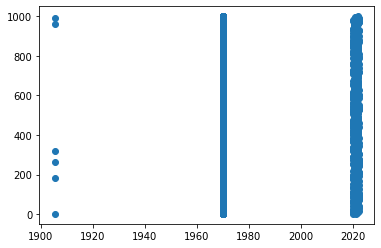

In [ ]:
plt.scatter(date,df['caseID'])
plt.show()

각 caseID를 날짜에 따라 시각화해보면, 1970년과 2020년에 데이터가 많이 모여 있는 것을 알 수 있습니다. 저는 이를 입력상의 오류라고 판단하여 1970년 데이터를 2020년으로 바꾸어 데이터 분석을 진행하고자 합니다. 1900년대 초반과 2022년 이후 데이터는 이상치로 판단하여 제거하겠습니다.

In [ ]:
df['date'] = df['date'].str.replace('1970','2020')

> 시간 변환 : object to datetime - 날짜와 시각으로 나뉘어 있던 시간 데이터를 하나로 통합하여 datetime 타입으로 변환

In [ ]:
#날짜, 시각 통합
df['datetime'] = df['date'] + ' ' + df['time']

In [ ]:
#datetime 타입으로 변환 
df['datetime'] = pd.to_datetime(df['datetime'])

> outlier 삭제 : 1970년 이전, 2022년 이후 데이터는 이상치로 판단

In [ ]:
century = df['datetime'] > '1970-01-01'
df = df[century]

In [ ]:
milen = df['datetime']<'2022-01-01'
df = df[milen]

In [ ]:
#필요없는 날짜, 시각 데이터 제거
df = df.drop(['date','time'],axis=1)

In [ ]:
#잘 변환되었는지 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13109 entries, 0 to 13261
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   caseID               13109 non-null  int64         
 1   taskID               13107 non-null  object        
 2   originator           13107 non-null  object        
 3   eventtype            13105 non-null  object        
 4   contact              989 non-null    object        
 5   RepairType           916 non-null    object        
 6   objectKey            916 non-null    float64       
 7   RepairInternally     917 non-null    object        
 8   EstimatedRepairTime  917 non-null    float64       
 9   RepairCode           917 non-null    float64       
 10  RepairOK             1826 non-null   object        
 11  datetime             13109 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 1.3+ MB


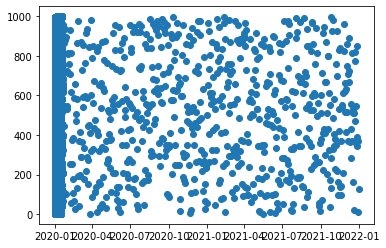

In [ ]:
plt.scatter(df['datetime'],df['caseID'])
plt.show()

#### caseID, 날짜로 정렬

In [ ]:
df = df.sort_values(by=['caseID','datetime'])

## 💡 Task 분석


In [ ]:
#사용할 특성만 남김
data = df[['caseID','taskID','originator','eventtype']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13109 entries, 11087 to 3604
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   caseID      13109 non-null  int64 
 1   taskID      13107 non-null  object
 2   originator  13107 non-null  object
 3   eventtype   13105 non-null  object
dtypes: int64(1), object(3)
memory usage: 512.1+ KB


In [ ]:
#taskID의 빈도를 알아보기 위해 One hot encoding을 이용
task = pd.get_dummies(data.taskID)

In [ ]:
task.head()

,ArrangeSurvey,ExternRepair,FirstContact,ImmediateRepair,InformClientSurvey,InformClientWrongPlace,InternRepair,MakeTicket,ReadyInformClient,RepairReady,SendTicketToFinAdmin,Survey,TicketReady
11087,0,0,0,0,0,0,0,1,0,0,0,0,0
4035,0,0,0,0,0,0,0,1,0,0,0,0,0
5098,1,0,0,0,0,0,0,0,0,0,0,0,0
4561,1,0,0,0,0,0,0,0,0,0,0,0,0
9171,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
data = pd.concat([data, task], axis=1) #인코딩한 결과를 결합

In [ ]:
data = data.drop('taskID',axis=1) #taskID의 인코딩이 끝났기 때문에 드랍

In [ ]:
data.head()

,caseID,originator,eventtype,ArrangeSurvey,ExternRepair,FirstContact,ImmediateRepair,InformClientSurvey,InformClientWrongPlace,InternRepair,MakeTicket,ReadyInformClient,RepairReady,SendTicketToFinAdmin,Survey,TicketReady
11087,1,Dian,start,0,0,0,0,0,0,0,1,0,0,0,0,0
4035,1,Dian,complete,0,0,0,0,0,0,0,1,0,0,0,0,0
5098,1,Dian,start,1,0,0,0,0,0,0,0,0,0,0,0,0
4561,1,Dian,complete,1,0,0,0,0,0,0,0,0,0,0,0,0
9171,1,System,complete,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
#eventtype이 complete인 것만 남기기
data = data[data.eventtype != 'start']

#### case별로 묶어보기

In [ ]:
grouped = data.groupby('caseID').sum()

In [ ]:
grouped.head()

,ArrangeSurvey,ExternRepair,FirstContact,ImmediateRepair,InformClientSurvey,InformClientWrongPlace,InternRepair,MakeTicket,ReadyInformClient,RepairReady,SendTicketToFinAdmin,Survey,TicketReady
caseID,,,,,,,,,,,,,
1,1,0,0,0,1,0,1,1,1,1,1,1,1
2,1,0,1,1,1,0,0,1,1,1,1,1,1
3,1,0,1,0,1,0,1,1,1,1,1,1,1
4,1,0,1,1,1,0,0,1,1,1,1,1,1
5,1,0,1,1,1,0,0,1,1,1,1,1,1


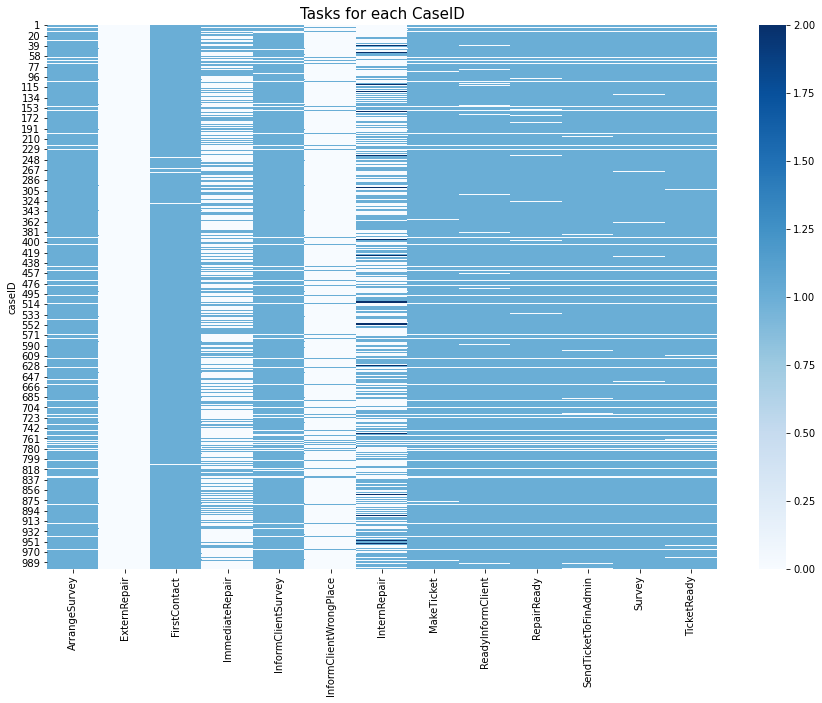

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(grouped,cmap='Blues',vmin=0, vmax=2)
plt.title('Tasks for each CaseID',fontsize=15)
plt.show() 

InformClientWrongPlace와 ExternRepair 이외에는 대부분의 프로세스가 1번 이상 진행된다는 것을 알 수 있습니다.


#### 사원별로 묶어보기

In [ ]:
originator = data.groupby('originator').sum()

In [ ]:
originator = originator.drop('caseID',axis=1)

In [ ]:
originator

,ArrangeSurvey,ExternRepair,FirstContact,ImmediateRepair,InformClientSurvey,InformClientWrongPlace,InternRepair,MakeTicket,ReadyInformClient,RepairReady,SendTicketToFinAdmin,Survey,TicketReady
originator,,,,,,,,,,,,,
Anne,0.0,0.0,0.0,183.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,217.0,0.0
Barbara,0.0,0.0,0.0,86.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,109.0,0.0
Ben,0.0,0.0,0.0,4.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,35.0,0.0
Cindy,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,94.0,0.0
Dian,438.0,0.0,460.0,0.0,0.0,29.0,0.0,431.0,0.0,0.0,0.0,0.0,0.0
Edd,0.0,0.0,0.0,0.0,0.0,0.0,105.0,0.0,0.0,0.0,0.0,79.0,0.0
Eric,0.0,0.0,0.0,4.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,23.0,0.0
Jacky,0.0,0.0,0.0,93.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,107.0,0.0
John,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,98.0,0.0


> 사원별 진행 업무 종류

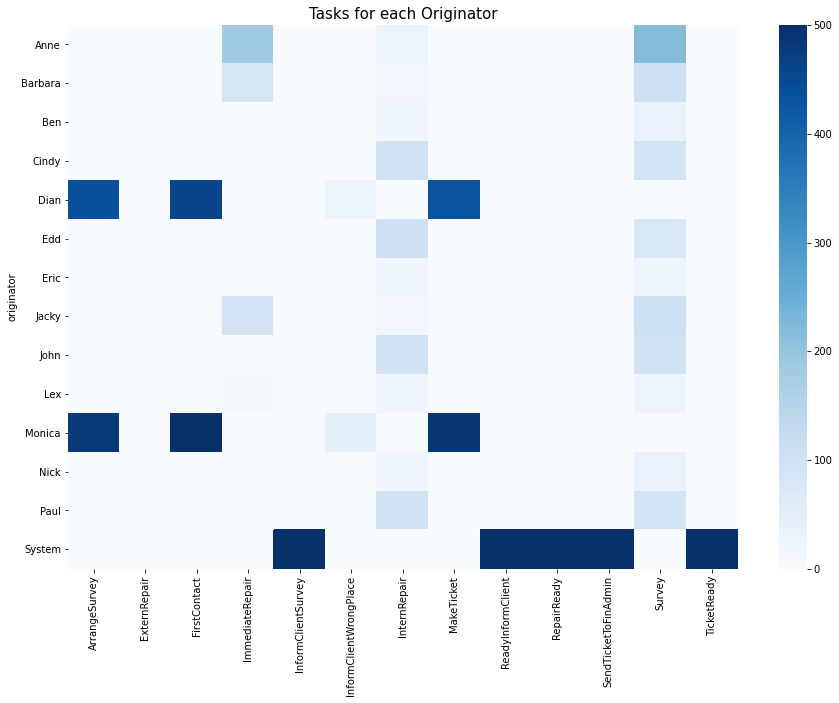

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(originator,cmap='Blues',vmax=500)
plt.title('Tasks for each Originator',fontsize=15)
plt.show() 

> 사원별 업무횟수

In [ ]:
originator.columns

Index(['ArrangeSurvey', 'ExternRepair', 'FirstContact', 'ImmediateRepair',
       'InformClientSurvey', 'InformClientWrongPlace', 'InternRepair',
       'MakeTicket', 'ReadyInformClient', 'RepairReady',
       'SendTicketToFinAdmin', 'Survey', 'TicketReady'],
      dtype='object')

In [ ]:
total = originator[originator.columns].sum(axis=1)

In [ ]:
total

originator
Anne        430.0
Barbara     209.0
Ben          60.0
Cindy       190.0
Dian       1358.0
Edd         184.0
Eric         49.0
Jacky       216.0
John        194.0
Lex          56.0
Monica     1539.0
Nick         54.0
Paul        192.0
System     4576.0
dtype: float64

In [ ]:
originator = pd.concat([originator,total],axis=1)

In [ ]:
originator.columns

Index([         'ArrangeSurvey',           'ExternRepair',
                 'FirstContact',        'ImmediateRepair',
           'InformClientSurvey', 'InformClientWrongPlace',
                 'InternRepair',             'MakeTicket',
            'ReadyInformClient',            'RepairReady',
         'SendTicketToFinAdmin',                 'Survey',
                  'TicketReady',                        0],
      dtype='object')

In [ ]:
originator.rename(columns={0:'total_task_counts'},inplace=True)

In [ ]:
originator.reset_index(inplace=True)

In [ ]:
originator

,originator,ArrangeSurvey,ExternRepair,FirstContact,ImmediateRepair,InformClientSurvey,InformClientWrongPlace,InternRepair,MakeTicket,ReadyInformClient,RepairReady,SendTicketToFinAdmin,Survey,TicketReady,total_task_counts
0,Anne,0.0,0.0,0.0,183.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,217.0,0.0,430.0
1,Barbara,0.0,0.0,0.0,86.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,109.0,0.0,209.0
2,Ben,0.0,0.0,0.0,4.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,35.0,0.0,60.0
3,Cindy,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,94.0,0.0,190.0
4,Dian,438.0,0.0,460.0,0.0,0.0,29.0,0.0,431.0,0.0,0.0,0.0,0.0,0.0,1358.0
5,Edd,0.0,0.0,0.0,0.0,0.0,0.0,105.0,0.0,0.0,0.0,0.0,79.0,0.0,184.0
6,Eric,0.0,0.0,0.0,4.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,23.0,0.0,49.0
7,Jacky,0.0,0.0,0.0,93.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,107.0,0.0,216.0
8,John,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,98.0,0.0,194.0
9,Lex,0.0,0.0,0.0,7.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,27.0,0.0,56.0


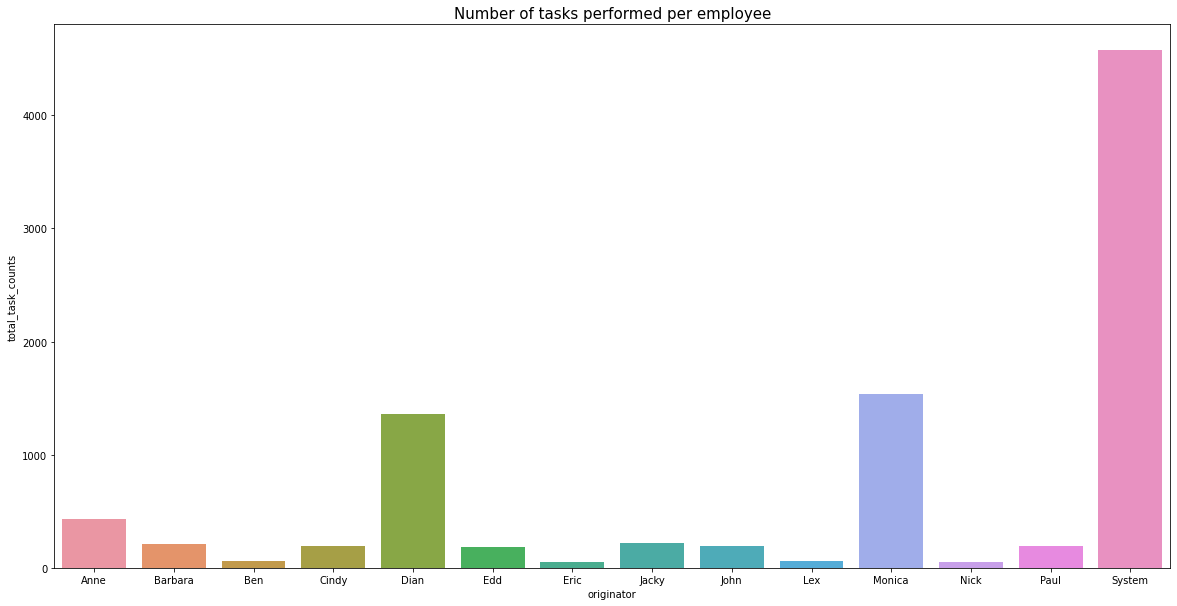

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(data = originator, x='originator',y='total_task_counts')
plt.title('Number of tasks performed per employee',fontsize=15)
plt.show()

## 💡 프로세스마이닝

In [ ]:
# 필요한 라이브러리 import - pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.visualization.dfg import factory as dfg_vis_factory
from pm4py.objects.conversion.dfg import factory as dfg_mining_factory
from pm4py.visualization.process_tree import factory as pt_vis_factory
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.algo.discovery.alpha import factory as alpha_miner
from pm4py.visualization.petrinet import factory as vis_factory
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.graphs import visualizer as graphs_visualizer
from pm4py.algo.discovery.heuristics import factory as heuristics_miner
from pm4py.visualization.petrinet import factory as hn_vis_factory
from pm4py.visualization.petrinet import factory as pn_vis_factory

In [ ]:
filtered = df[['caseID','taskID','eventtype','datetime']]

In [ ]:
filtered = filtered[filtered.eventtype != 'start'] # eventtype이 complete인 데이터만 남김

In [ ]:
filtered

,caseID,taskID,eventtype,datetime
4035,1,MakeTicket,complete,2020-01-02 08:11:00
4561,1,ArrangeSurvey,complete,2020-01-02 08:16:00
9171,1,InformClientSurvey,complete,2020-01-02 08:16:00
3835,1,Survey,complete,2020-01-11 21:56:00
1994,1,InternRepair,complete,2020-01-17 08:12:00
...,...,...,...,...
11985,1000,Survey,complete,2020-01-16 14:58:00
5081,1000,RepairReady,complete,2020-01-19 18:34:00
8609,1000,InternRepair,complete,2020-01-19 18:34:00
2987,1000,ReadyInformClient,complete,2020-01-20 02:25:00


In [ ]:
filtered = filtered.drop('eventtype',axis=1) #데이터 분리에 사용했으므로 eventtype은 드랍

> 기존 데이터를 로그 형태로 변환

In [ ]:
cols = ['case:concept:name','concept:name','time:timestamp']

In [ ]:
filtered.columns = cols

In [ ]:
filtered.head()

,case:concept:name,concept:name,time:timestamp
4035,1,MakeTicket,2020-01-02 08:11:00
4561,1,ArrangeSurvey,2020-01-02 08:16:00
9171,1,InformClientSurvey,2020-01-02 08:16:00
3835,1,Survey,2020-01-11 21:56:00
1994,1,InternRepair,2020-01-17 08:12:00


In [ ]:
filtered['case:concept:name'] = filtered['case:concept:name'].astype(str)

In [ ]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9311 entries, 4035 to 3604
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   case:concept:name  9311 non-null   object        
 1   concept:name       9309 non-null   object        
 2   time:timestamp     9311 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 291.0+ KB


In [ ]:
# 기존 데이터를 로그 형태의 데이터프레임으로 변환

log = log_converter.apply(filtered, variant=log_converter.Variants.TO_DATA_FRAME) 

> DFG(Directly Follows Graph) 도출

In [ ]:
from pm4py.algo.discovery.dfg import algorithm as dfg_algorithm

dfg = dfg_algorithm.apply(log)

In [ ]:
net, im, fm = dfg_mining_factory.apply(dfg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecatedWarning:

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead



> 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecatedWarning:

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecatedWarning:

view is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.



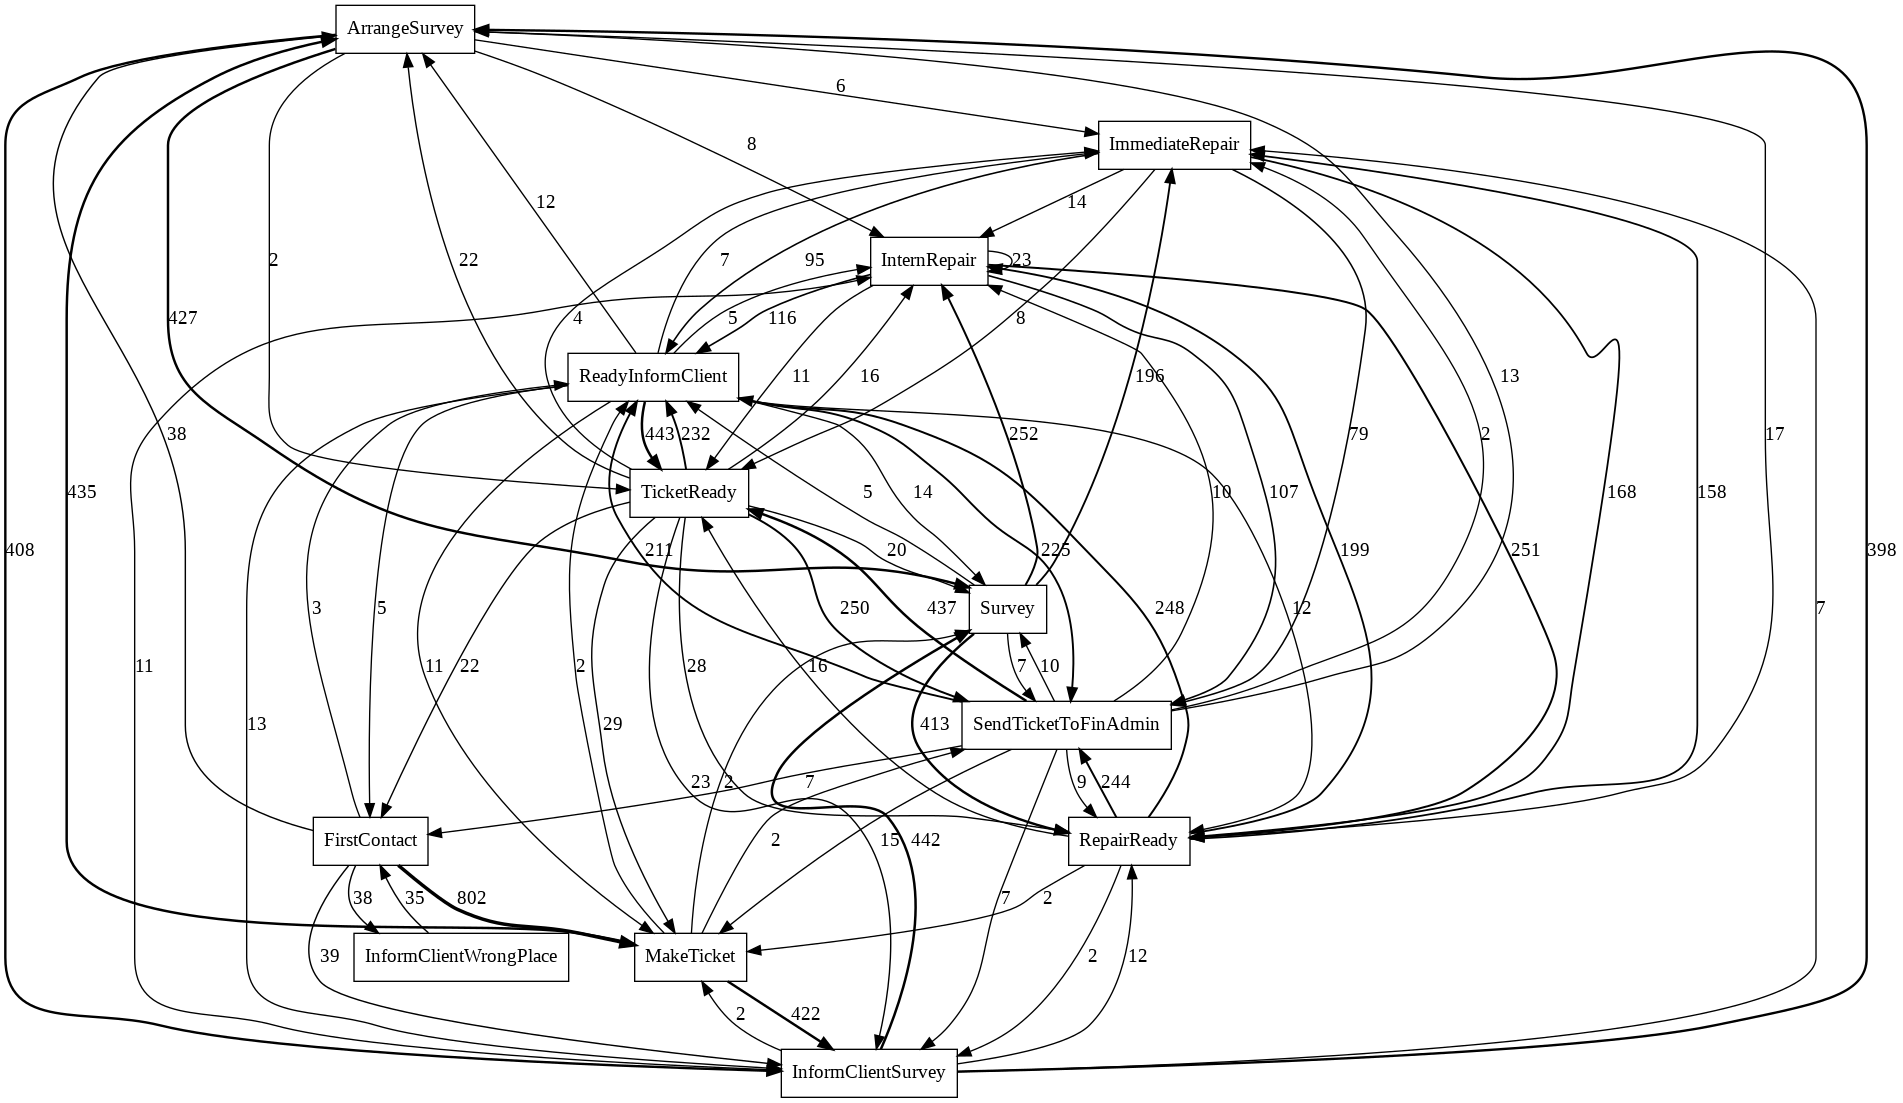

In [ ]:
gviz = dfg_vis_factory.apply(dfg, log = log, variant='frequency')
dfg_vis_factory.view(gviz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecatedWarning:

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecatedWarning:

view is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.



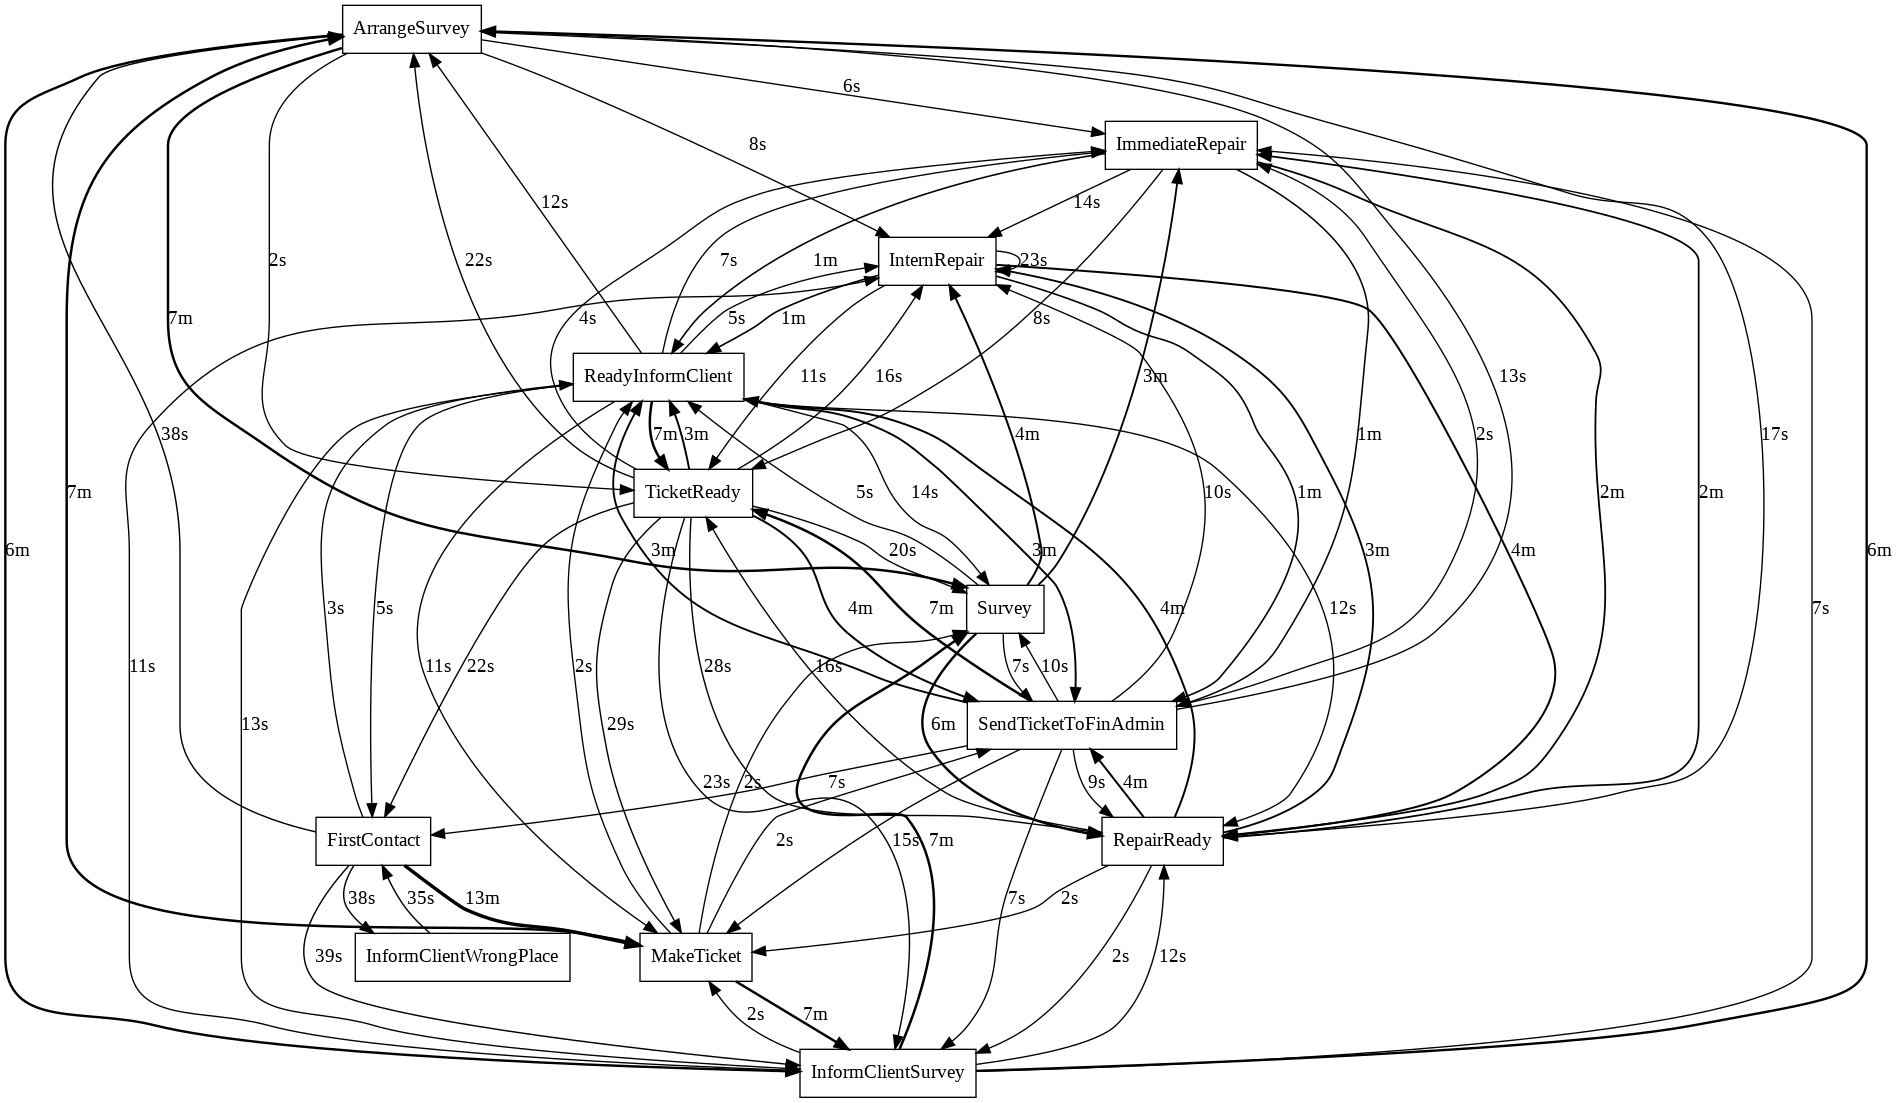

In [ ]:
gviz = dfg_vis_factory.apply(dfg, log = log, variant='performance')
dfg_vis_factory.view(gviz)

> DFG를 Petri Net으로 나타냄 

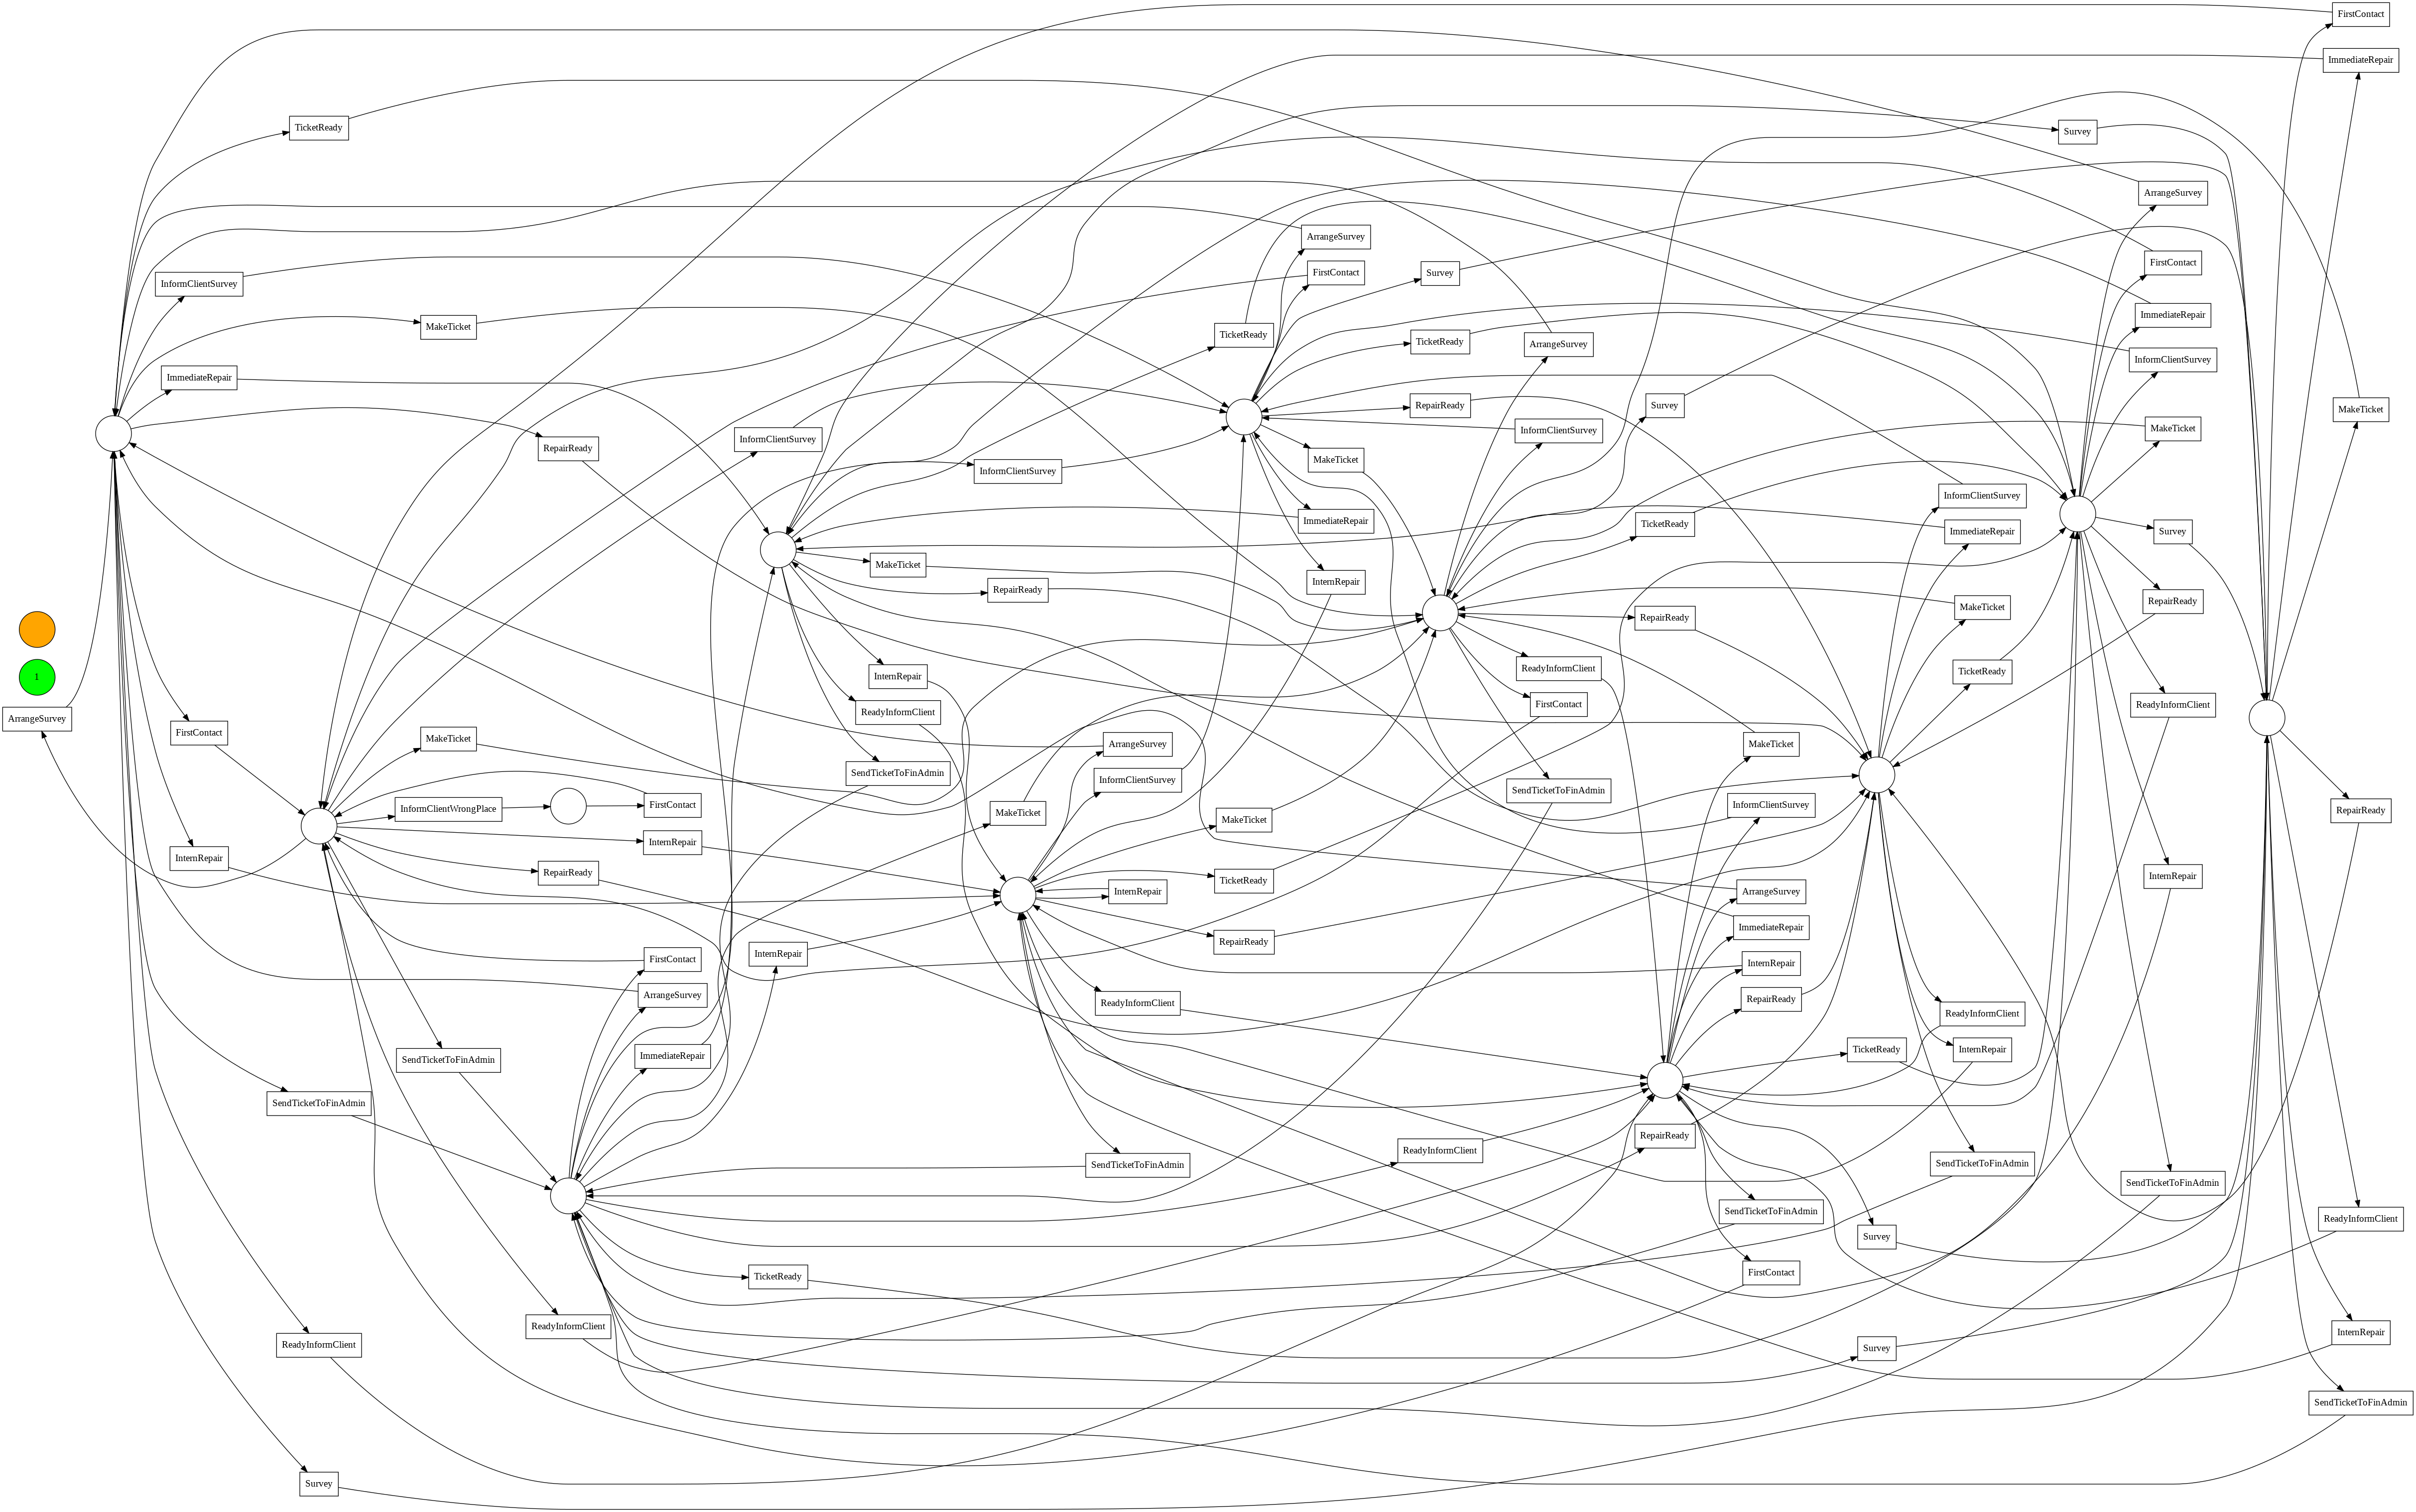

In [ ]:
gviz_in = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz_in)

> 알파 알고리즘을 이용하여 프로세스 모델 도출

In [ ]:
al_net, al_ini, al_fin = alpha_miner.apply(log)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecatedWarning:

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecatedWarning:

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecatedWarning:

view is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.



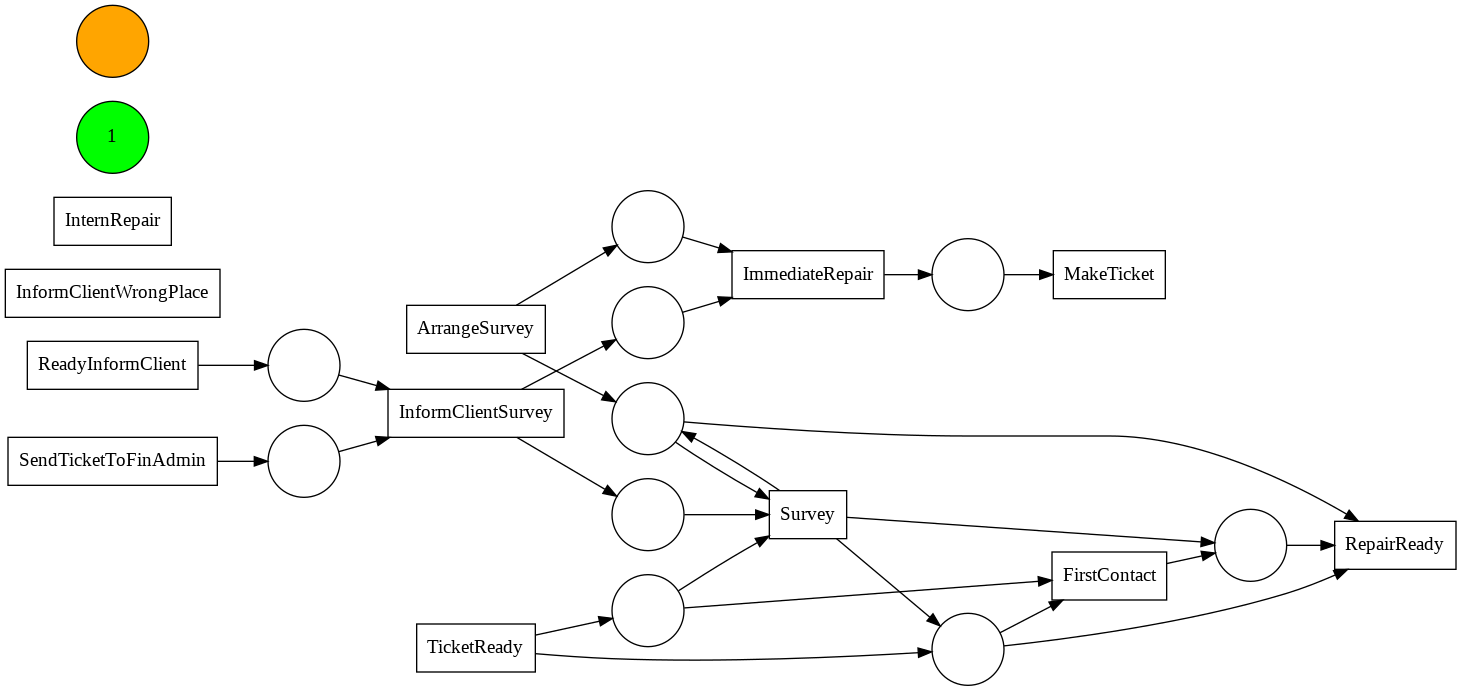

In [ ]:
al_gviz = vis_factory.apply(al_net, al_ini, al_fin)
vis_factory.view(al_gviz)

> Heuristic mining 

- 휴리스틱 마이너로 도출된 휴리스틱 넷으로부터 페트리넷 도출

In [ ]:
heu_net, heu_im, heu_fm = heuristics_miner.apply(log, parameters={'dependency_thresh':0.6, 'min_act_count':2})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecatedWarning:

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecatedWarning:

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecatedWarning:

view is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.



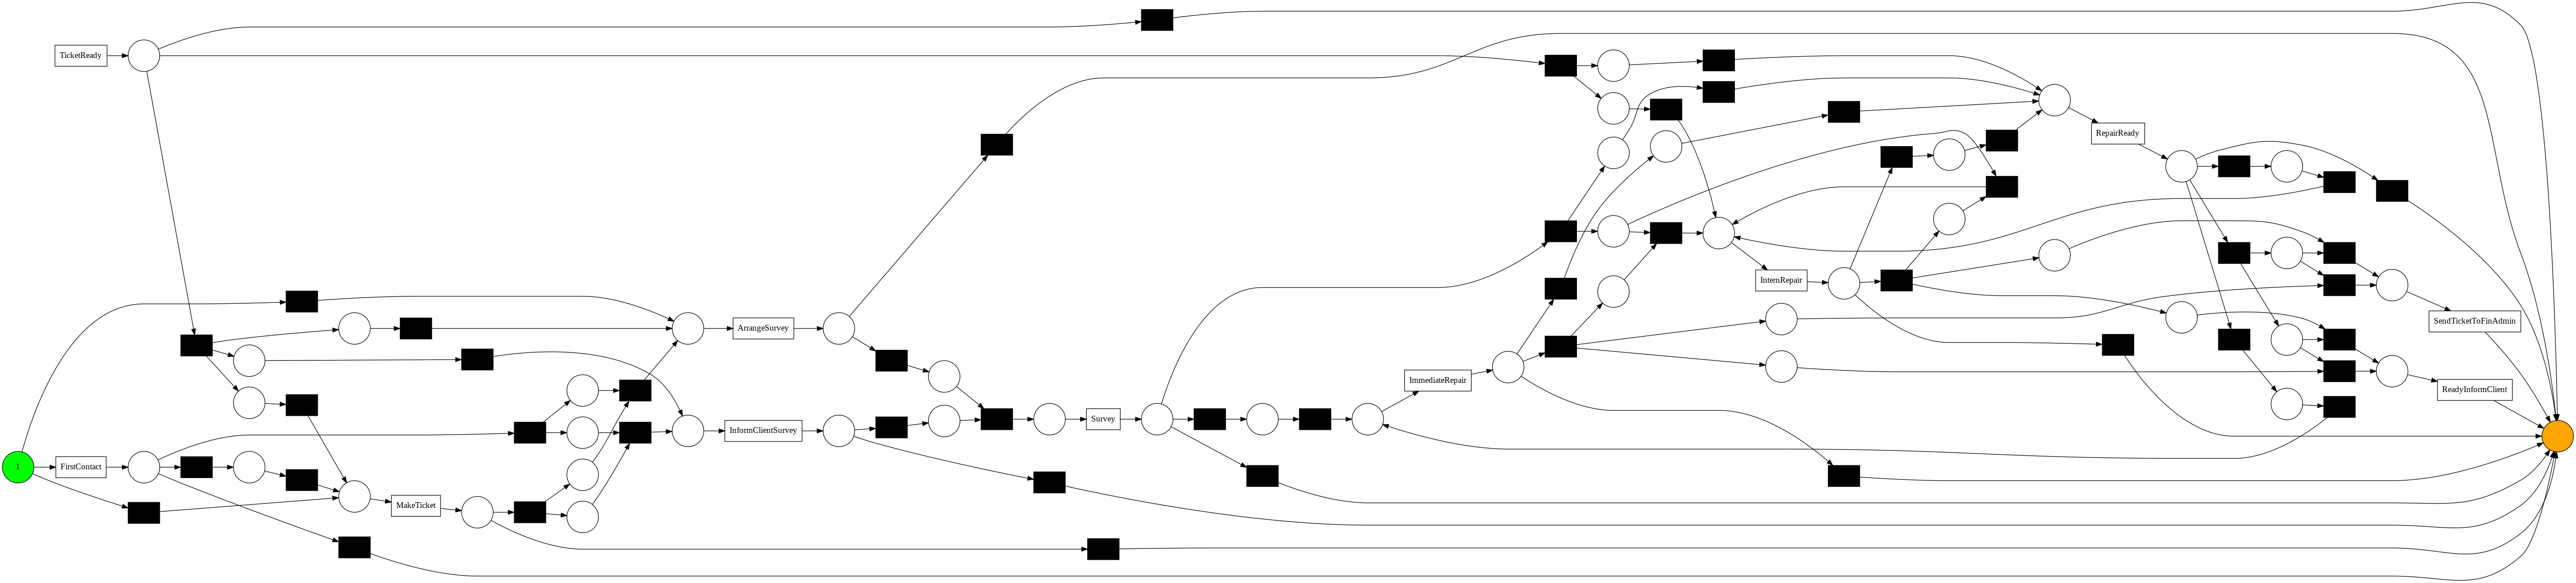

In [ ]:
gviz_heu = pn_vis_factory.apply(heu_net, heu_im, heu_fm)
pn_vis_factory.view(gviz_heu)